# Our best model so far

Packages

In [1]:
import os 
import re

# data manipulation/viz
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# modeling setups
from patsy import dmatrices
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler

# linear modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from statsmodels.formula.api import glm 

# tree modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# other
from sklearn.decomposition import PCA

# turn off the df['col'] = x assignment warning
pd.options.mode.chained_assignment = None  # default='warn'

Load and data clean

In [44]:
# optional directory set-up
train = pd.read_csv("../../housing_data/train.csv")
real_test = pd.read_csv("../../housing_data/test.csv")
real_sample = pd.read_csv("../../housing_data/sample_submission.csv")

In [342]:
# train =pd.read_csv('C:/Users/19258/Downloads/house-prices-advanced-regression-techniques/train.csv')
# test = pd.read_csv("C:/Users/19258/Downloads/house-prices-advanced-regression-techniques/test.csv")
# sample = pd.read_csv("C:/Users/19258/Downloads/house-prices-advanced-regression-techniques/sample_submission.csv")

Data clean functions

In [45]:
#train is train, test is dev for plotting
sample = train[1022:][['Id','SalePrice']].reset_index().drop('index', axis = 1)
test = train[1022:].drop(['SalePrice'], axis = 1).reset_index().drop('index', axis = 1)
train = train[:1022].reset_index().drop('index', axis = 1)



In [46]:
def na_clean(df):
    
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df[var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df[var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df['MasVnrType'].fillna('None', inplace = True)
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['MSZoning'].fillna('RL', inplace = True)
    df['SaleType'].fillna('WD', inplace = True)
    df['Utilities'].fillna('AllPub', inplace = True)
    df['KitchenQual'].fillna('TA', inplace = True)
    df['Functional'].fillna('Typ', inplace = True)

    # other cat vars just put missing if there isn't a glaring most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd', 'FireplaceQu']
    for var in replace_missing_vars:
        df[var].fillna("Missing", inplace = True)

    return df



# Function for some standard feature engineering to use in all models
def standard_feature_eng(df, test_data = False):
    '''Input either the training or test data. 
    2nd arg set to True if it's the testing data. That way we ignore the final log transformation on sale price'''

    # num features to just binarize b/c few houses have the feature
    df["SwimmingPool"] = df['PoolArea'].map(lambda x: 0 if x==0 else 1)
    df["3SsnPorch"] = df['3SsnPorch'].map(lambda x: 0 if x==0 else 1)
    df["ScreenPorch"] = df['ScreenPorch'].map(lambda x: 0 if x==0 else 1)

    # re-factoring vars:
    # group the irregularities into 2 factor levels
    df['LotShape'] = df['LotShape'].map({'Reg': 'Reg', 'IR1': 'Reg', 'IR2': 'Irreg', 'IR3': 'Irreg'})

    # simplifying MSSubClass because we have the year built in another feature
    df['MSSubClass'] = df['MSSubClass'].map(lambda x: 
        "1_story"   if (x in (20, 30, 40, 120)) else(
        "1.5_story" if (x in (45, 50, 150)) else(
        "2_story"   if (x in (60, 70, 75, 160, 180, 190)) else(
        "split"     if (x in (80, 85)) else(
        "duplex"    if (x ==90) else(
        "other"))))))
    df['MSSubClass'] = df['MSSubClass'].astype("object")

    # simplifying more vars
    # electrical:
    df['Electrical'] = df['Electrical'].map(lambda x: "SBrkr" if x == "SBrkr" else "Fuse")
    # exterior:
    df['Exterior'] = df['Exterior1st'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Expensive" if (x in ("VinylSd", "CemntBd", "Stone", "ImStucc")) else(
        "Cheap" if (x in ("BrkComm", "AsphShn", "CBlock", "AsbShng")) else(
        "Moderate")))
    df = df.drop(columns=['Exterior1st', 'Exterior2nd'])
    # garage
    df['GarageQual'] = df['GarageQual'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Good" if (x in ("Ex", "Gd")) else(
        "Medium" if (x in ("TA")) else(
        "Bad")))
    df['Heating'] = df['Heating'].map(lambda x: "Gas" if x in ("GasA", "GasW") else "Other")

    # deciding to drop a few features for various reasons
    vars_to_drop = [
        # not much variation:
        "LowQualFinSF", 
        "LandSlope", 
        "MiscVal", 
        "RoofMatl",
        "Condition2",
        #"KitchenAbvGr" # hardly any variation. But, Deva included in lm's so including it now.
        "PoolArea", # binarized above
        "Utilities", # only 1 obs in training data different from regular
        "HouseStyle" # already explained in other vars
        ]
    df.drop(columns=vars_to_drop, inplace=True) 

    # adding a remodeled feature
    df['Remodeled'] = (df.YearRemodAdd-df.YearBuilt) == 0

    # total inside area will be a sum of 1st and 2nd floor sq ft
    df['Total_Inside_Area'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(columns = ['1stFlrSF', '2ndFlrSF', 'GrLivArea'], inplace = True)

    # simplify the bathrooms variable
    df['Bathrooms'] = df.BsmtFullBath + 0.5*df.BsmtHalfBath + df.FullBath + 0.5*df.HalfBath
    df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace = True)

    # get log of sale price which will be our actual response variable
    if test_data:
        pass 
    else:
        
        df['LogSalePrice'] = np.log(df.SalePrice)

    return df


OLS with 16 features predicting regular sale price

In [47]:
def lm_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    lm_vars = ['LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 
              'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 
             'MoSold', 'Remodeled', 'Total_Inside_Area', 'Bathrooms', 'GarageCars', 'BsmtFinSF1']
#, 'YearRemodAdd',
        #'LotFrontage','WoodDeckSF', 'GarageArea'
    
    df = pd.get_dummies(df[lm_vars], 
        columns = ['Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'BsmtCond','KitchenQual'], 
        drop_first=True)

    #lm_vars = ['LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 
    #          'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 
    #          'MoSold', 'Remodeled', 'Total_Inside_Area', 'Bathrooms', 'GarageCars', 'BsmtFinSF1', 'YearRemodAdd',
    #    'LotFrontage','WoodDeckSF', 'GarageArea']
    
    #df = pd.get_dummies(df[lm_vars], 
    #    columns = [ 'OverallQual', 'OverallCond', 'BsmtCond','KitchenQual'], 
    #    drop_first=True)
    return df


# data setups
X_train = lm_df_clean(train)
X_test = lm_df_clean(test, test_data=True)
Y_train = train.SalePrice
Y_test = sample.SalePrice

# fit to train data
lr_1 = LinearRegression(fit_intercept=True).fit(X_train, Y_train)

# evaluate performance
print("Score on training data: {:.3f}".format(lr_1.score(X_train,Y_train)))
print("Score on testing data: {:.3f}".format(lr_1.score(X_test ,Y_test)))

yhat_train = lr_1.predict(X_train)
yhat_test = lr_1.predict(X_test)

# rmse
rmse_train = (np.mean((np.log(yhat_train) - np.log(Y_train))**2))**.5
rmse_test = (np.mean((np.log(yhat_test) - np.log(Y_test))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.883


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 61 is different from 56)

OLS with 1 variable (overall quality) predicting regular sale price

In [48]:
# data setup function
def lm_overall_quality_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)
    df = df.loc[:, ['OverallQual']]
    
    return df

# data setups
X_train = lm_overall_quality_df_clean(train)
X_test = lm_overall_quality_df_clean(test, test_data=True)
Y_train = train.SalePrice
Y_test = sample.SalePrice

# fit to train data
lr_overall_quality = LinearRegression(fit_intercept=True).fit(X_train, Y_train)

# Evaluate performance
print("Score on training data: {:.3f}".format(lr_overall_quality.score(X_train,Y_train)))
print("Score on testing data: {:.3f}".format(lr_overall_quality.score(X_test ,Y_test)))

yhat_train = lr_overall_quality.predict(X_train)
yhat_test = lr_overall_quality.predict(X_test)

# set negative values to 0.1
yhat_train = np.array([0.1 if i < 0 else i for i in yhat_train])
yhat_test = [0.1 if i < 0 else i for i in yhat_test]

# rmse
rmse_train = (np.mean((np.log(yhat_train) - np.log(Y_train))**2))**.5
rmse_test = (np.mean((np.log(yhat_test) - np.log(Y_test))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.635
Score on testing data: 0.604
Log RMSE on training data: 0.859
Log RMSE on testing data: 0.690


Lasso predicting log sale price

In [49]:
# first build one hot encoder based on the training data
train_lasso = standard_feature_eng(na_clean(train))
enc_lasso = OneHotEncoder(handle_unknown = 'ignore')
enc_lasso.fit(train_lasso.select_dtypes(include=["object"]))
one_hot_columns = pd.get_dummies(train_lasso.select_dtypes(include=["object"])).columns
# will use this encoder in the function below



# data setup function
def lasso_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    
    df = standard_feature_eng(df, test_data = test_data)
    
    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_lasso.transform(df.select_dtypes(include=["object"])).toarray())
    
    categorical_cols.columns = one_hot_columns
    
    #df = df.reset_index().drop(columns='index')
    #categorical_cols = categorical_cols.reset_index().drop(columns='index')
    
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # log transformations
    #df["GrLivArea"] = np.log(df["GrLivArea"])
    df.Total_Inside_Area = np.log(df.Total_Inside_Area)
    df.LotArea = np.log(df.LotArea)
    for x in range(len(df.BsmtFinSF1)):
        if df['BsmtFinSF1'][x] ==0:
            df['BsmtFinSF1'][x] = 1
    df.BsmtFinSF1 = np.log(df.BsmtFinSF1)
    
    # select only vars needed
    if test_data:
        df = df.drop(columns=["Id"])
    else:
        df = df.drop(columns=["Id"])
        
        df['SalePrice'] = np.log(df['SalePrice'])
        #df = df[["GrLivArea","OverallQual", "SalePrice"]]
    
    return df


# data setups
X_train = lasso_df_clean(train)
X_test = lasso_df_clean(test, test_data=True)
Y_train = X_train.SalePrice
X_train = X_train.drop(columns=['LogSalePrice', 'SalePrice'])
Y_test = np.log(sample.SalePrice)



# fit to train data
lasso_fit = Lasso(alpha=0.000001).fit(X_train, Y_train)


# Evaluate performance
yhat_train = lasso_fit.predict(X_train)
yhat_test = lasso_fit.predict(X_test)

# Evaluate performance
print("Score on training data: {:.3f}".format(lasso_fit.score(X_train,Y_train)))
print("Score on testing data: {:.3f}".format(lasso_fit.score(X_test ,Y_test)))

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.939
Score on testing data: 0.873
Log RMSE on training data: 0.100
Log RMSE on testing data: 0.137


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9147476858887007, tolerance: 0.016765455330608848
  model = cd_fast.enet_coordinate_descent(


Random Forest to predict log sale price

In [50]:
# first build one hot encoder based on the training data
train_rf = standard_feature_eng(na_clean(train))
enc_rf = OneHotEncoder(handle_unknown = 'ignore')
enc_rf.fit(train_rf.select_dtypes(include=["object"]))
one_hot_columns = pd.get_dummies(train_rf.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# Random forest data clean function
def rf_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_rf.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns
    
    #df = df.reset_index().drop(columns='index')
    #categorical_cols = categorical_cols.reset_index().drop(columns='index')
    
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # DO FEATURE ENGINEERING HERE
    # drop irrelevant columns

    df = df.drop(columns=["Id"])
    
    return df


# preprocess the data
df_rf = rf_df_clean(train)
df_rf_test = rf_df_clean(test, test_data=True)

# run model on best parameters
rf_reg = RandomForestRegressor(
    n_estimators = 900,
    max_depth = 25,
    max_features = 'auto',
    min_samples_split = 2,  
    bootstrap = True, 
    )

# fit the model
rf_reg = rf_reg.fit(df_rf.drop(columns = ["SalePrice", 'LogSalePrice']), df_rf.LogSalePrice)

# Evaluate performance
yhat_train = rf_reg.predict(df_rf.drop(columns = ["SalePrice", 'LogSalePrice']))
yhat_test = rf_reg.predict(df_rf_test)

# Evaluate performance
print("Score on training data: {:.3f}".format(rf_reg.score(df_rf.drop(columns = ["SalePrice", 'LogSalePrice']), df_rf.LogSalePrice)))
print("Score on testing data: {:.3f}".format(rf_reg.score(df_rf_test, np.log(sample.SalePrice))))

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 0.982
Score on testing data: 0.859
Log RMSE on training data: 0.054
Log RMSE on testing data: 0.145


XGBoost to predict log sale price

In [51]:
# first build one hot encoder based on the training data
train_xgb = standard_feature_eng(na_clean(train))
enc_xgb = OneHotEncoder(handle_unknown = 'ignore')
enc_xgb.fit(train_xgb.select_dtypes(include=["object"]))
one_hot_columns_xgb = pd.get_dummies(train_xgb.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# xgboost data clean function
def xgb_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_xgb.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns_xgb
    
    #df = df.reset_index().drop(columns='index')
    #categorical_cols = categorical_cols.reset_index().drop(columns='index')
    
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # DO MORE FEATURE ENGINEERING HERE LATER
    df = df.drop(columns = ['Id'])
    
    return df


# preprocess the data
df_xgb = xgb_df_clean(train)
df_xgb_test = xgb_df_clean(test, test_data=True)

# get X feature names
xgb_cols = np.array(df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']).columns)

# train/test split
dev_train_X, dev_test_X, dev_train_y, dev_test_y = train_test_split(
    df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']), 
    np.log(df_xgb['SalePrice']), 
    test_size=0.2, random_state=1)

xgb_reg_cv = xgb.XGBRegressor(
    booster="gbtree",
    verbosity=0,
    subsample=.5,  
    colsample_bytree=.7, 
    random_state=1  
)

cv_grid = {
    "n_estimators": [500, 600], 
    "max_depth": [10, 15, 20],
    "learning_rate": [.05, .1], 
    'reg_alpha': [0, .01], 
    'reg_lambda': [0, .1], 
}

# takes 10 min to run
# gscv = GridSearchCV(estimator=xgb_reg_cv, param_grid=cv_grid, n_jobs=-1, cv=3)

# fit step
# xgb_cv_results = gscv.fit(dev_train_X, dev_train_y)
# print(xgb_cv_results.best_params_)
# {'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 500, 'reg_alpha': 0.01, 'reg_lambda': 0.1}

Now build final XGB model with optimal parameters

In [52]:
# first build one hot encoder based on the training data
train_xgb = standard_feature_eng(na_clean(train))
enc_xgb = OneHotEncoder(handle_unknown = 'ignore')
enc_xgb.fit(train_xgb.select_dtypes(include=["object"]))
one_hot_columns_xgb = pd.get_dummies(train_xgb.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# xgboost data clean function
def xgb_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_xgb.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns_xgb
    
    #df = df.reset_index().drop(columns='index')
    #categorical_cols = categorical_cols.reset_index().drop(columns='index')
    
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # DO MORE FEATURE ENGINEERING HERE LATER
    df = df.drop(columns = ['Id'])
    
    return df


# preprocess the data
df_xgb = xgb_df_clean(train)
df_xgb_test = xgb_df_clean(test, test_data=True)

# final hyper params
xgb_reg = xgb.XGBRegressor(
    booster="gbtree",
    verbosity=0,
    subsample=.5,  
    colsample_bytree=.7, 
    random_state=1,

    n_estimators=500, 
    max_depth=20,
    learning_rate=.05, 
    reg_alpha=.01, 
    reg_lambda=0.1
)

# fit model
xgb_reg.fit(df_xgb.drop(columns=['SalePrice', 'LogSalePrice']), df_xgb['LogSalePrice'])

# performance on train/test
yhat_train = xgb_reg.predict(df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']))
yhat_test = xgb_reg.predict(df_xgb_test)

# Evaluate performance
print("Score on training data: {:.3f}".format(xgb_reg.score(df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']), df_xgb.LogSalePrice)))
print("Score on testing data: {:.3f}".format(xgb_reg.score(df_xgb_test, np.log(sample.SalePrice))))

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Score on training data: 1.000
Score on testing data: 0.903
Log RMSE on training data: 0.001
Log RMSE on testing data: 0.120


Final Ensemble model

In [53]:
def housing_ensemble_model(df):
    '''This is the final model that takes in raw data, and makes predictions'''

    # OLS
    #yhat_ols1 = lr_1.predict(lm_df_clean(df, test_data=True))

    # OLS Simple
    yhat_ols_simple = lr_overall_quality.predict(lm_overall_quality_df_clean(df, test_data=True))

    # GLM

    # Lasso
    lasso_data = lasso_df_clean(df, test_data=True)
    yhat_lasso = np.exp(lasso_fit.predict(lasso_data))

    # Random forest
    yhat_rf = np.exp(rf_reg.predict(rf_df_clean(df, test_data=True)))

    # XGB
    xgb_data = xgb_df_clean(df, test_data=True)
    yhat_xgb = np.exp(xgb_reg.predict(xgb_data))

    # make ensemble prediction
    # Do more work to come up w/ weights. This is just a sample
    yhat_final = yhat_ols_simple * (0.075) + yhat_lasso * (0.575) + yhat_rf * (0.3) + yhat_xgb * (0.05)

    return yhat_final


# final ensemble model RMSE
yhat_train = housing_ensemble_model(train.drop(columns = ["SalePrice"]))
yhat_test = housing_ensemble_model(real_test)

rmse_train = np.mean((train.SalePrice - yhat_train)**2)**.5
rmse_test = np.mean((real_sample.SalePrice - yhat_test)**2)**.5

# evaluate rmse  on the testing data
print("RMSE Train: {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))

# log results
rmse_train_log = np.mean((np.log(train.SalePrice) - np.log(yhat_train))**2)**.5
rmse_test_log = np.mean((np.log(real_sample.SalePrice) - np.log(yhat_test))**2)**.5
# evaluate rmse  on the testing data
print("\nLog RMSE Train: {}".format(rmse_train_log))
print("Log RMSE Test: {}".format(rmse_test_log))

RMSE Train: 16926.194396819792
RMSE Test: 70124.21116378637

Log RMSE Train: 0.08073113207742925
Log RMSE Test: 0.373319539235062


In [14]:
real_sample

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [38]:
yhat_test.shape

(1459,)

Create sample submission

In [39]:
sample_submission = pd.DataFrame({
    "Id": real_test.Id,
    "SalePrice": yhat_test
})
sample_submission.to_csv("~/Desktop/sample_submission_11-26.csv", index=False)

In [18]:
yhat_test.shape

(1459,)

Kaggle Score: 0.12328

Rank: 612 / 4770 = 12.8%

In [54]:
df = test

'''This is the final model that takes in raw data, and makes predictions'''

# OLS
#yhat_ols1 = lr_1.predict(lm_df_clean(df, test_data=True))

# OLS Simple
yhat_ols_simple = lr_overall_quality.predict(lm_overall_quality_df_clean(df, test_data=True))

# GLM

# Lasso
lasso_data = lasso_df_clean(df, test_data=True)
yhat_lasso = np.exp(lasso_fit.predict(lasso_data))

# Random forest
yhat_rf = np.exp(rf_reg.predict(rf_df_clean(df, test_data=True)))

# XGB
xgb_data = xgb_df_clean(df, test_data=True)
yhat_xgb = np.exp(xgb_reg.predict(xgb_data))

# make ensemble prediction
# Do more work to come up w/ weights. This is just a sample
yhat_final = yhat_ols_simple * (0.075) + yhat_lasso * (0.575) + yhat_rf * (0.3) + yhat_xgb * (0.05)

    


# final ensemble model RMSE
yhat_train = housing_ensemble_model(train.drop(columns = ["SalePrice"]))
yhat_test = housing_ensemble_model(test)

rmse_train = np.mean((train.SalePrice - yhat_train)**2)**.5
rmse_test = np.mean((sample.SalePrice - yhat_test)**2)**.5

# evaluate rmse  on the testing data
print("RMSE Train: {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))

# log results
rmse_train_log = np.mean((np.log(train.SalePrice) - np.log(yhat_train))**2)**.5
rmse_test_log = np.mean((np.log(sample.SalePrice) - np.log(yhat_test))**2)**.5
# evaluate rmse  on the testing data
print("\nLog RMSE Train: {}".format(rmse_train_log))
print("Log RMSE Test: {}".format(rmse_test_log))

RMSE Train: 16926.194396819792
RMSE Test: 31402.425943725913

Log RMSE Train: 0.08073113207742925
Log RMSE Test: 0.12920422924227307


Text(0, 0.5, 'Actual Price')

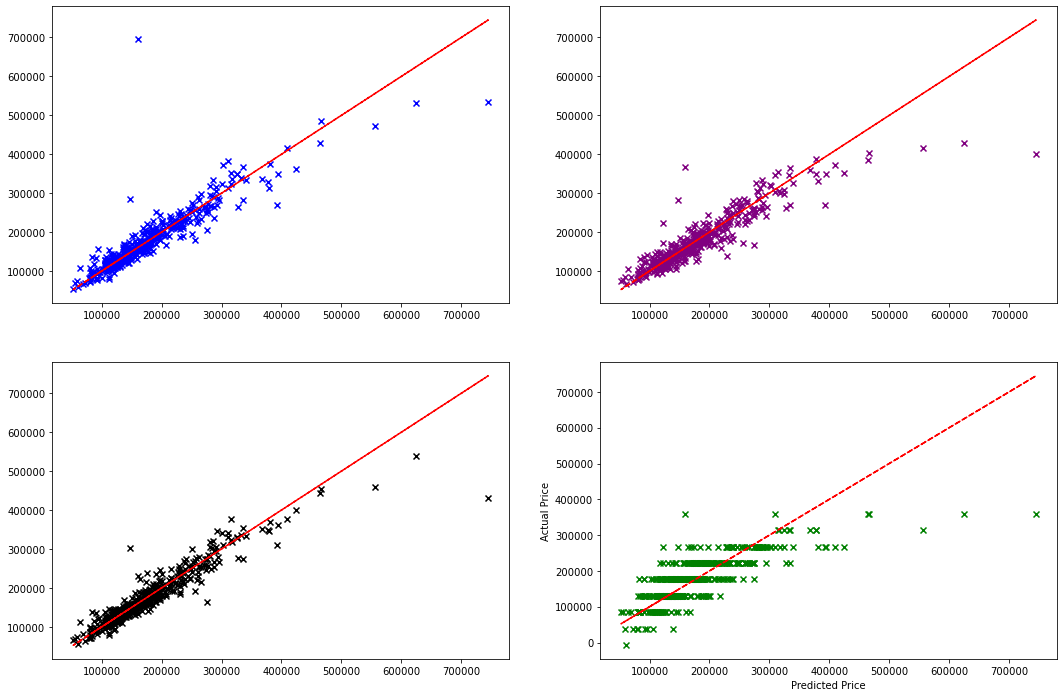

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(18,12))

axs[0, 0].scatter(sample.SalePrice, yhat_lasso, marker = 'x', c ='blue')
axs[0, 0].plot(sample.SalePrice, sample.SalePrice, 'r--')

axs[0, 1].scatter(sample.SalePrice, yhat_rf, marker = 'x', c ='purple')
axs[0, 1].plot(sample.SalePrice, sample.SalePrice, 'r--')

axs[1, 0].scatter(sample.SalePrice, yhat_xgb, marker = 'x', c ='black')
axs[1, 0].plot(sample.SalePrice, sample.SalePrice, 'r--')

axs[1, 1].scatter(sample.SalePrice, yhat_ols_simple, marker = 'x', c ='green')
axs[1, 1].plot(sample.SalePrice, sample.SalePrice, 'r--')

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
